In [1]:
from pathlib import Path

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = Path("dataset_segmentation_small/")
path_lbl = path / "labels"
path_img = path / "images"

In [5]:
get_labels = lambda x: path_lbl / x.name
codes = np.array(['background','fruit'], dtype='str'); codes       

array(['background', 'fruit'], dtype='<U10')

In [6]:
fnames = get_image_files(path_img/ "train")
mnames = get_image_files(path_lbl)

In [7]:
m = open_mask(mnames[0])

In [8]:
np.unique(m.data)

array([  0, 255])

In [9]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['background','fruit']

In [25]:
#src_size = np.array(open_image(fnames[0]).shape[1:]) #get sample shape, need to change this for full dataset
size = 256
bs=8


In [26]:
src = (SegItemListCustom.from_folder(path_img)
       .split_by_folder()
       .label_from_func(get_labels, classes=codes))

In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
data.classes

['background', 'fruit']

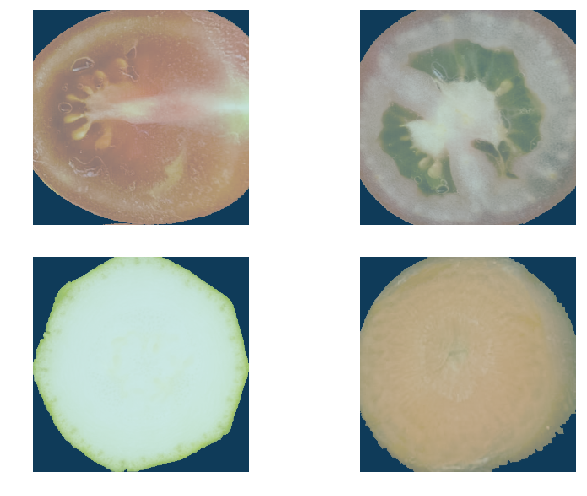

In [29]:
data.show_batch(2, figsize=(10,7))

In [30]:
def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [31]:
learn = unet_learner(data, models.resnet34, metrics=seg_accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


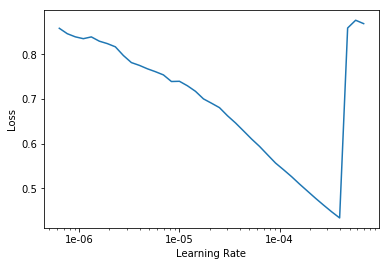

In [32]:
lr_find(learn)
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,segaccuracy,time
0,0.051827,0.017512,0.993809,00:52
1,0.016956,0.009718,0.996715,00:51
2,0.006957,0.006374,0.997874,00:51
3,0.011956,0.006149,0.997609,00:51
4,0.004991,0.004527,0.998243,00:51
5,0.003845,0.004398,0.998334,00:52
6,0.004449,0.004236,0.998314,00:52
7,0.004368,0.003497,0.998541,00:52
8,0.003365,0.003570,0.998467,00:52
9,0.003250,0.003575,0.998463,00:52


In [35]:
learn.save('stage-1-256-small_images')

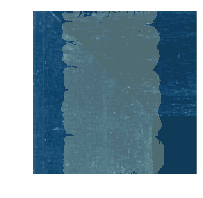

In [56]:
#img = data.train_ds[80][0]
img = open_image('dataset_segmentation/images/albicocche1.png')
mask = learn.predict(img)[0]
mask.save('mask_test.png')
img.show(y=mask)

In [1]:
mask.show(figsize=(5, 5), alpha=1)

NameError: name 'mask' is not defined